# TMT4260 Modelling of Phase Transformations in Metals and Alloys

## Exercise 2

Edit: 2017-09-07

By Håkon W. Ånes

___

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import warnings

warnings.filterwarnings('ignore')
fsize = 15
newparams = {'axes.titlesize': fsize, 'axes.labelsize': fsize,
             'axes.linewidth': 2, 'savefig.dpi': 200, 
             'lines.linewidth': 2.0, 'lines.markersize': 7, 
             'figure.figsize': (16, 5), 'figure.subplot.wspace': 0.4,
             'ytick.labelsize': fsize, 'xtick.labelsize': fsize,
             'ytick.major.pad': 3, 'xtick.major.pad': 3,
             'xtick.major.size': 2, 'ytick.major.size': 2,
             'legend.handlelength': 1.5, 'legend.fontsize': fsize}
plt.rcParams.update(newparams)

For an A-B binary alloy system with solid and liquid regular solutions the Gibbs free energies for solid and liquid at equilibrium are equal

$$
G^{\mathrm{L}} = G^{\mathrm{S}} \Rightarrow \Delta G = 0.
$$

It then follows from Gibbs-Helmholtz relationship that

$$
\Delta S = \frac{\Delta H}{T_{\mathrm{m}}} = \frac{L}{T_{\mathrm{m}}},
$$

where $L$ is the latent heat of melting. Close to equilibrium, ignoring the difference in the specific heats of the liquid and solid in both pure A and pure B, $\Delta H$ and $\Delta S$ are approximately independent of temperature. This gives

$$
\Delta G \approx L - L\frac{T}{T_{\mathrm{m}}} = L\Bigl(1 - \frac{T}{T_{\mathrm{m}}}\Bigr) = \frac{L\Delta T}{T_{\mathrm{m}}}.
$$

Assuming a heterogeneous solution, the components must have the same chemical potentials $\mu$ in the solid and liquid phases, $\mu_{\mathrm{A}}^{\mathrm{L}} = \mu_{\mathrm{A}}^{\mathrm{S}}$ and likewise for $B$. Using the expression above for the free energy of mixing close to equilibrium, a set of equations for the equilibrium compositions $X_{\mathrm{A}}$ and $X_{\mathrm{B}}$ can be derived

\begin{align*}
    \mu_{\mathrm{A}}^{\mathrm{L}} & = \mu_{\mathrm{A}}^{\mathrm{S}} \\
    G_{\mathrm{A}}^{\mathrm{L}} + RT\ln \bigl(1 - X_{\mathrm{B}}^{\mathrm{L}}\bigr) + \Omega_{\mathrm{L}}\bigl(X_{\mathrm{B}}^{\mathrm{L}}\bigr)^2 & = G_{\mathrm{A}}^{\mathrm{S}} + RT\ln \bigl(1 - X_{\mathrm{B}}^{\mathrm{S}}\bigr) + \Omega_{\mathrm{S}}\bigl(X_{\mathrm{B}}^{\mathrm{S}}\bigr)^2 \\
\end{align*}

\begin{align*}
    \Rightarrow \Delta G_{\mathrm{A}} & = RT\bigl[\ln \bigl(1 - X_{\mathrm{B}}^{\mathrm{S}}\bigr) - \ln \bigl(1 - X_{\mathrm{B}}^{\mathrm{L}}\bigr)\bigr] + \Omega_{\mathrm{S}}\bigl(X_{\mathrm{B}}^{\mathrm{S}}\bigr)^2 - \Omega_{\mathrm{L}}\bigl(X_{\mathrm{B}}^{\mathrm{L}}\bigr)^2 = \Delta H_{\mathrm{A}}\bigl(1 - \frac{T}{T_{\mathrm{m,A}}}\bigr), \\
    \Delta G_{\mathrm{B}} & = RT\bigl(\ln X_{\mathrm{B}}^{\mathrm{S}} - \ln X_{\mathrm{B}}^{\mathrm{L}}\bigr) + \Omega_{\mathrm{S}}\bigl(1 - X_{\mathrm{B}}^{\mathrm{S}}\bigr)^2 - \Omega_{\mathrm{L}}\bigl(1 - X_{\mathrm{B}}^{\mathrm{L}}\bigr)^2 = \Delta H_{\mathrm{B}}\bigl(1 - \frac{T}{T_{\mathrm{m,B}}}\bigr).
\end{align*}

We implement a function for inserting a value for $X_{\mathrm{B}}^{\mathrm{S}}$ and finding roots for $X_{\mathrm{B}}^{\mathrm{L}}$ and $T$. (The function explanation [docstring] might be a bit overkill, but is nice to have.)

In [2]:
def equilibrium_composition(xblT, *data):
    """Calculate the liquid equilibrium composition and the temperature
    at a certain solidus equilibrium composition.

    Parameters
    ----------
    xblT : list
        Starting estimates for xbl and T.
    data : tuple
        With the variables xbs, omegas, omegal, TmA, TmB, deltaHfA and
        deltaHfB (see below).
    xbs : float
        Solid equilibrium composition.
    omegas : int
        Avogadro's number times the number of bonds per atom times
        the difference between the A–B bond energy and the average of
        the A–A and B–B bond energies, for the solid solution.
    omegal : int
        Avogadro's number times the number of bonds per atom times
        the difference between the A–B bond energy and the average of
        the A–A and B–B bond energies, for the liquid solution.
    TmA : int
        Melting point for element A in K.
    TmB : int
        Melting point for element B in K.
    deltaHfa : int
        Latent heat for element A in cal/mol.
    deltaHfb : int
        Latent heat for element B in cal/mol.

    Returns
    -------
    out : list
        Pair of nonlinear equations to pass on to a root finding
        algorithm.

    """
    # Unpack arguments
    xbl, T = xblT
    xbs, omegas, omegal, TmA, TmB, deltaHfa, deltaHfb = data

    # Define constants
    R = 8.314472/4.184  # [cal/mol K]
    
    # Pair of nonlinear equations
    out = [R*T*(np.log(1 - xbs) - np.log(1 - xbl)) + omegas*xbs**2 \
           - omegal*xbl**2 - deltaHfa*(1 - T/TmA)]
    out.append(R*T*(np.log(xbs) - np.log(xbl)) + omegas*(1 - xbs)**2 \
               - omegal*(1 - xbl)**2 - deltaHfb*(1 - T/TmB))

    return out

Substituting Matlab's `fsolve` blindly for `scipy`'s `scipy.optimize.fsolve` produces ugly, nonsensical results. Turns out, as explained in [this Stackoverflow answer](https://stackoverflow.com/questions/21885093/comparing-fsolve-results-in-python-and-matlab), that Matlab's `fsolve` uses the Levenberg-Marquardt algorithm, also known as the damped-least-squares method. This is implemented in [`scipy.optimize.root`](https://docs.scipy.org/doc/scipy/reference/optimize.root-lm.html#optimize-root-lm) when specifying `method=lm`, hence this is what we use below. The algorithm also needs an initial step bound, which is set to 0.01 in Matlab.

First we calculate the compositions and the temperature, then we plot (parts of) the phase diagrams.

## Ideal solution $\Omega = 0$

In [3]:
# Declare arrays and calculate compositions and the temperature
# while varying xbs
xbsid = np.linspace(0.01, 0.99, 300)
xblid = np.zeros(np.shape(xbsid))
tempsid = np.zeros(np.shape(xbsid))

for i in range(len(xbsid)):
    # Initial guesses xbl = 0.5 and T = 750. For the extra arguments
    # see the function definition for equilibrium_composition above
    sol = sco.root(equilibrium_composition, [0.5, 750],
                   args=(xbsid[i], 0, 0, 900, 600, 2000,
                         1300), method='lm', options={'factor': 0.01})
    # The roots are stored in sol.x
    xblid[i], tempsid[i] = sol.x

## Regular solution $\Omega_{\mathrm{L}} = 0, \Omega_{\mathrm{S}} = 1500$

In [4]:
xbsreg = np.linspace(0.01, 0.99, 300)
xblreg = np.zeros(np.shape(xbsreg))
tempsreg = np.zeros(np.shape(xbsreg))

for i in range(len(xbsreg)):
    sol = sco.root(equilibrium_composition, [0.5, 750],
                   args=(xbsreg[i], 1500, 0, 900, 600, 2000,
                         1300), method='lm', options={'factor': 0.01})
    xblreg[i], tempsreg[i] = sol.x

## Plot (parts of) the phase diagrams

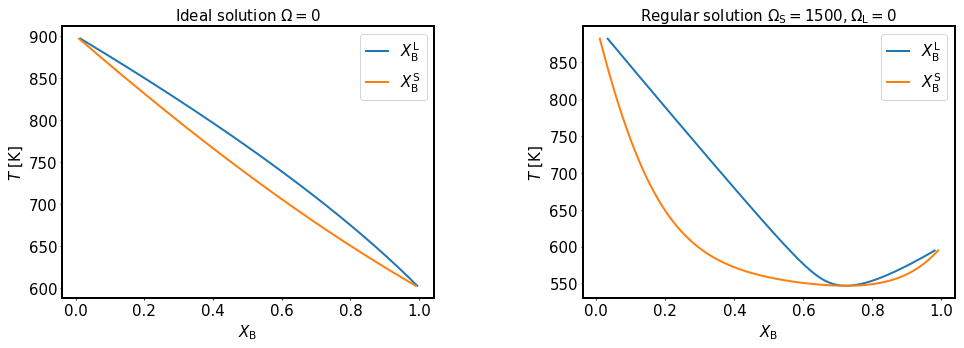

In [5]:
fig, ax = plt.subplots(ncols=2)

ax[0].plot(xblid, tempsid, label='$X_{\mathrm{B}}^{\mathrm{L}}$')
ax[0].plot(xbsid, tempsid, label='$X_{\mathrm{B}}^{\mathrm{S}}$')
ax[0].set_xlabel('$X_{\mathrm{B}}$')
ax[0].set_ylabel('$T$ [K]')
ax[0].set_title('Ideal solution $\Omega = 0$')
ax[0].legend();

ax[1].plot(xblreg, tempsreg, label='$X_{\mathrm{B}}^{\mathrm{L}}$')
ax[1].plot(xbsreg, tempsreg, label='$X_{\mathrm{B}}^{\mathrm{S}}$')
ax[1].set_xlabel('$X_{\mathrm{B}}$')
ax[1].set_ylabel('$T$ [K]')
ax[1].set_title('Regular solution $\Omega_{\mathrm{S}} = 1500, \
                \Omega_{\mathrm{L}} = 0$')
ax[1].legend();

For the ideal solution, the solid phase is stable across all compositions. This is also the case for the regular solution, however in an approximate composition interval $X_{\mathrm{B}} \in [0.7, 0.75]$ at $T \approx 550$ K, both phases have the same Gibbs free energy.